In [167]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

# Processing Data

In [168]:
def processing_data(file_path):

  if not isinstance(file_path, str):

    raise ValueError("Not a string.")

  # Reading Excel File
  df_heart_dis = pd.read_excel(file_path)

  # Removing Duplicate Rows
  df_heart_dis = df_heart_dis.drop_duplicates()

  # Removing Empty Rows
  df_heart_dis = df_heart_dis.dropna()

  # Removing Uncessary columns
  columns_to_drop = ["height", "weight", "age", "bp_category_encoded", "id"]

  df_heart_dis.drop(columns = columns_to_drop, inplace = True)

  # Converting Male(2) = 0 & Female(1) = 1
  df_heart_dis["gender"] = df_heart_dis["gender"].apply(lambda x: 0 if x == 2 else 1)

  # Converting "Yes" = 1 & "No" = -1
  df_heart_dis["cardio"] = df_heart_dis["cardio"].map(lambda x: -1 if x == 0 else 1)

  # One Hot-Encoding
  labels = {
    1: "normal",
    2: "above_normal",
    3: "well_above_normal"
  }

  df_heart_dis["cholesterol"] = df_heart_dis["cholesterol"].map(labels)
  df_heart_dis["gluc"] = df_heart_dis["gluc"].map(labels)

  df_heart_dis = pd.get_dummies(df_heart_dis, columns = ["bp_category", "cholesterol", "gluc"], prefix = ["bp_category", "chol", "gluc"])

  dummy_cols = [col for col in df_heart_dis.columns if col.startswith(("bp_category", "chol", "gluc"))]

  df_heart_dis[dummy_cols] = df_heart_dis[dummy_cols].astype(int) # Converting True = 1 & False = 0

  # Normalising Numerical Data
  num_cols = ["ap_hi", "ap_lo","age_years", "bmi"]

  scaler = StandardScaler()

  df_heart_dis[num_cols] = scaler.fit_transform(df_heart_dis[num_cols])

  return df_heart_dis

In [169]:
df_heart_dis = processing_data("cardiovascular_dataset.xlsx")

print("Class Distribution:\n", df_heart_dis["cardio"].value_counts(),"\n")
print(df_heart_dis.head(5))

Class Distribution:
 cardio
-1    34533
 1    33672
Name: count, dtype: int64 

   gender     ap_hi     ap_lo  smoke  alco  active  cardio  age_years  \
0       0 -1.029656 -0.138226      0     0       1      -1  -0.417089   
1       1  0.849859  0.955397      0     0       1       1   0.321479   
2       1  0.223354 -1.231849      0     0       0       1  -0.269376   
3       0  1.476363  2.049021      0     0       1       1  -0.712516   
4       1 -1.656161 -2.325472      0     0       0      -1  -0.860230   

        bmi  bp_category_Elevated  bp_category_Hypertension Stage 1  \
0 -0.919843                     0                                 1   
1  1.230768                     0                                 0   
2 -0.664190                     0                                 1   
3  0.199116                     0                                 0   
4 -0.746598                     0                                 0   

   bp_category_Hypertension Stage 2  bp_category_Norma

# Training, Validation & Testing

---



In [170]:
X_data = df_heart_dis.drop(columns = "cardio")
y_target = df_heart_dis["cardio"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_data,
    y_target,
    test_size = 0.2, # 20% for testing
    random_state = 42,
    stratify = y_target
    )

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_train,
    y_train,
    test_size = 0.125,       #10% of training for validation
    random_state = 42,
    stratify = y_train
)

# Converting to Tensors
x_train = torch.from_numpy(X_train.values).float()
x_val = torch.from_numpy(X_val.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1) # shape(kx1)

y_val = torch.from_numpy(y_val.values).float()
y_val = y_val.reshape(-1, 1) # shape(kx1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1) # shape(kx1)

# Adding Bias term
x_train = torch.cat([x_train, torch.ones(x_train.size(0), 1)], dim = 1)
x_val = torch.cat([x_val, torch.ones(x_val.size(0), 1)], dim = 1)
x_test = torch.cat([x_test, torch.ones(x_test.size(0), 1)], dim = 1)

print("Number of Features: {}".format(x_train.shape[1]))
print(x_train[0])
print(y_train[0])

print("\nNumber of Examples:{}".format(len(df_heart_dis)))
print("\nTraining Examples:{}".format(len(x_train)))
print("Validation Examples:{}".format(len(x_val)))
print("Testing Examples:{}".format(len(x_test)))

Number of Features: 19
tensor([ 1.0000, -0.4032, -0.1382,  0.0000,  0.0000,  1.0000, -0.2694, -0.9249,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  1.0000])
tensor([-1.])

Number of Examples:68205

Training Examples:47743
Validation Examples:6821
Testing Examples:13641


In [171]:
# Creating DataLoaders for mini batch SGD
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

# Classification Model

In [172]:
class LinearSVM(torch.nn.Module):

  def __init__(self, num_features):

    super().__init__()

    self.weight = torch.nn.Parameter(torch.zeros(1, num_features), requires_grad = True)
    torch.nn.init.xavier_uniform_(self.weight) # Applying Xavier initialization


  def forward(self, x):

    z = torch.matmul(x, self.weight.T)

    return z

In [173]:
def hinge_loss(outputs, labels, margin = 0.5):

    loss = torch.mean(torch.clamp(margin - outputs * labels, min = 0))

    return loss

# Training Model

In [174]:
def compute_metrics(true_labels, pred_labels):

  tp, fp = 0, 0
  tn, fn = 0, 0

  true_labels = ((true_labels + 1) // 2) # If 1 then 1 and if -1 then 0
  pred_labels = ((pred_labels + 1) // 2) # If 1 then 1 and if -1 then 0

  for true, pred in zip(true_labels, pred_labels):

    if true == 1 and pred == 1:

      tp += 1

    elif true == 0 and pred == 0:

      tn += 1

    elif true == 0 and pred == 1:

      fp += 1

    else:

      fn += 1

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  return accuracy, precision, recall, f1_score

In [175]:
num_features = x_train.shape[1]
model = LinearSVM(num_features)

lr = 0.001 # best lr = 0.001
optmizer = torch.optim.SGD(model.parameters(), lr = lr)

In [176]:
def train(model, train_loader, val_loader, optmizer, num_epochs):

  train_losses = []
  train_accs = []

  val_losses = []
  val_accs = []

  for epoch in range(num_epochs):

    model.train()

    loss_per_epoch = 0
    acc_per_epoch = 0

    print(f'\nEpoch {epoch + 1}/{num_epochs}.')

    for batch_x, batch_y in train_loader:

      train_logits = model(batch_x)

      train_loss = hinge_loss(train_logits, batch_y)

      optmizer.zero_grad()

      train_loss.backward()

      optmizer.step()

      train_preds = torch.sign(train_logits)

      train_acc, _, _, _ = compute_metrics(batch_y, train_preds)

      loss_per_epoch += train_loss.item()
      acc_per_epoch += train_acc

    avg_train_loss = loss_per_epoch / len(train_loader)
    train_losses.append(avg_train_loss)

    avg_train_acc = acc_per_epoch / len(train_loader)
    train_accs.append(avg_train_acc * 100)

    print("Train Loss:{}, Acc:{}".format(avg_train_loss, avg_train_acc * 100))

    #------Evaluating Model on Validation Dataset---------
    model.eval()

    loss_per_epoch = 0
    acc_per_epoch = 0

    with torch.no_grad():

      for batch_x, batch_y in val_loader:

        val_logits = model(batch_x)
        val_loss = hinge_loss(val_logits, batch_y)

        val_preds = torch.sign(val_logits)

        val_acc, _, _, _ = compute_metrics(batch_y, val_preds)

        loss_per_epoch += val_loss.item()
        acc_per_epoch += val_acc

      avg_val_loss = loss_per_epoch / len(val_loader)
      val_losses.append(avg_val_loss)

      avg_val_acc = acc_per_epoch / len(val_loader)
      val_accs.append(avg_val_acc * 100)

      print("Val Loss:{}, Acc:{}".format(avg_val_loss, avg_val_acc * 100))


  #------Plotting Loss and Accuracy Values---------
  plt.figure(figsize = (12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label = "Training Loss")
  plt.legend(loc = "best")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.subplot(1, 2, 2)
  plt.plot(val_losses, label = "Validation Loss")
  plt.legend(loc = "best")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.tight_layout()
  plt.show()

  plt.plot(train_accs, label = "Training accuracy")
  plt.plot(val_accs, label = "Validation accuracy")
  plt.legend(loc = "best")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy(%)")

  plt.show()


Epoch 1/20.
Train Loss:0.46298133363153277, Acc:59.36364913949668
Val Loss:0.4259031844612594, Acc:64.37207943925233

Epoch 2/20.
Train Loss:0.391385990646905, Acc:67.01926403182564
Val Loss:0.3945435191565585, Acc:67.72196261682244

Epoch 3/20.
Train Loss:0.3723986413599499, Acc:68.94809954164144
Val Loss:0.38122033571528496, Acc:69.05957943925233

Epoch 4/20.
Train Loss:0.3605688330455216, Acc:69.93271912565943
Val Loss:0.36657121053365904, Acc:69.51810747663552

Epoch 5/20.
Train Loss:0.3518756108093837, Acc:70.1989913949667
Val Loss:0.3595206981925207, Acc:70.14018691588785

Epoch 6/20.
Train Loss:0.3452113047042417, Acc:70.61154112254606
Val Loss:0.3522129663936446, Acc:70.78855140186916

Epoch 7/20.
Train Loss:0.33995058687139135, Acc:70.81058656922944
Val Loss:0.34747477293571577, Acc:70.78271028037383

Epoch 8/20.
Train Loss:0.3358512374974448, Acc:70.99267328980369
Val Loss:0.34366810356623656, Acc:70.96670560747664

Epoch 9/20.
Train Loss:0.3326098524912912, Acc:71.170841260

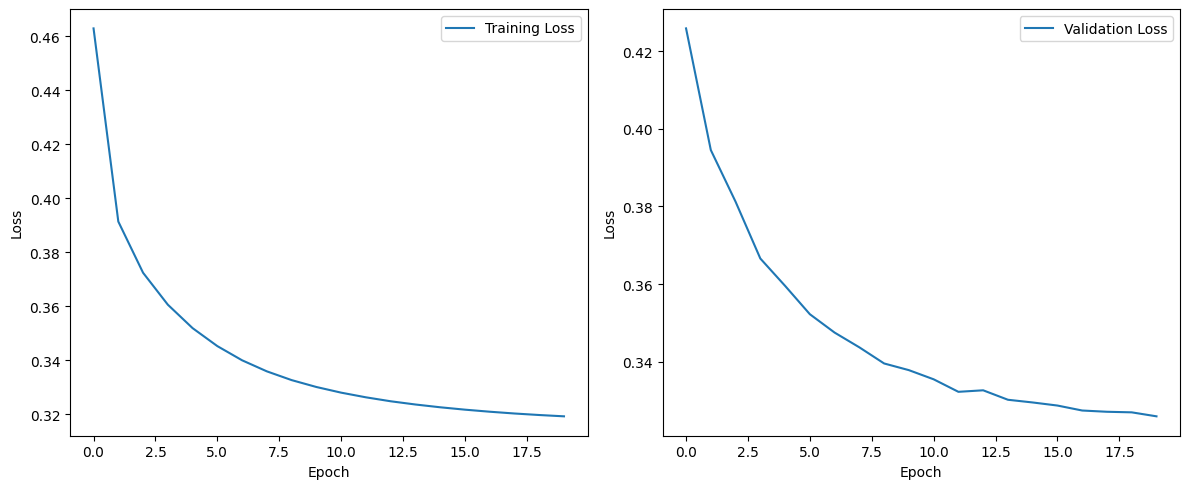

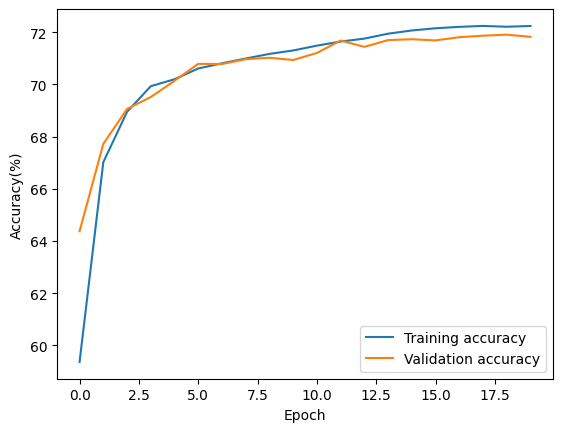

In [177]:
train(model, train_loader, val_loader, optmizer, num_epochs = 20)

# Evaluating Model

In [178]:
def eval (model, x_test, y_test):

  model.eval()

  with torch.no_grad():

    logits = model(x_test)
    l = hinge_loss(logits, y_test)

    predictions = torch.sign(logits)

    accuracy, precision, recall, f1_score = compute_metrics(y_test, predictions)

    print("Test Loss:{}\n".format(l.item()))
    print("Accuracy:{}".format(accuracy * 100))
    print("Precision:{}".format(precision))
    print("Recall:{}".format(recall))
    print("F1-Score:{}".format(f1_score))

In [179]:
eval(model, x_test, y_test)

Test Loss:0.3185831606388092

Accuracy:72.03284216699656
Precision:0.7958645854449625
Recall:0.583011583011583
F1-Score:0.6730093425902116


# Saving Classifier

In [180]:
#import joblib

#joblib.dump(model, "SVM_model.joblib")